## Tools and Imports

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [308]:
stockData = pd.read_csv("mldata.csv")
stockData.head()

,Stat,Role,Best Attributes,Result
0,0,0,0,1
1,0,1,1,1
2,1,2,0,1
3,1,3,2,1
4,0,0,0,0


## Basic EDA

<AxesSubplot:>

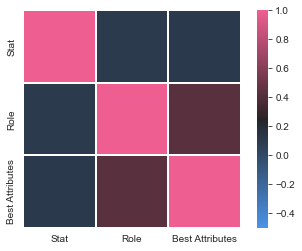

In [309]:
corr = stockData.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

plotting of columns

<AxesSubplot:xlabel='Best Attributes', ylabel='Count'>

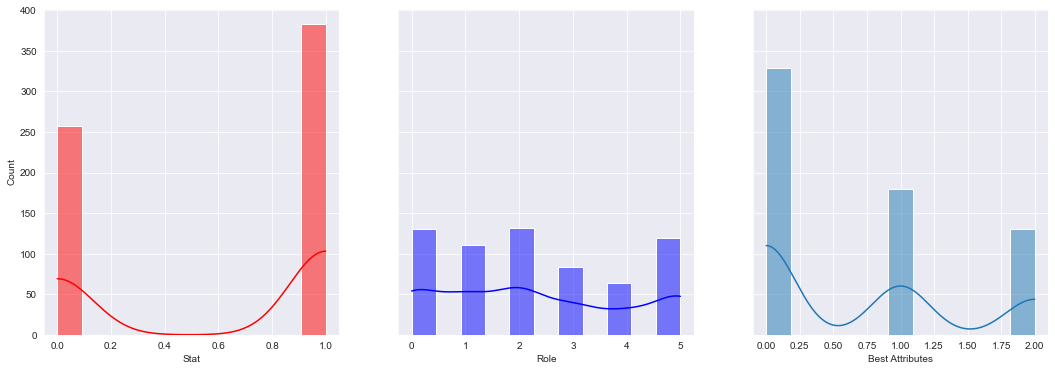

In [310]:
fig, axes = plt.subplots(1,3, figsize=(18,6), sharey=True)
sns.histplot(stockData, ax=axes[0], x="Stat", kde=True, color='r')
sns.histplot(stockData, ax=axes[1], x="Role", kde=True, color='b')
sns.histplot(stockData, ax=axes[2], x="Best Attributes", kde=True)

## Calculate Prior P(Y)
Logic for this would be P(Y) = totalY/totalN; Y = Win | Lose

In [61]:
def calculate_prior(df,Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==1])/len(df))
    return prior

## Calculate P(X|Y) 
logic here is P(X|Y) = totalX/totalN; X = x0 | x1 | x2 (columns)

In [211]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate Probability P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y) * P(Y)

In [305]:
def naive_bayes_categorical(df, X, Y):
    #getting the feature names
    features = list(df.columns)[:-1]
    
    prior = calculate_prior(df, Y)
    
    probW = []
    probL = []
    Ypred = []
    data = [[],[],[]]
    accumulatedP = [],[]
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            #calculate P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y)
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])
        
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
            
        Ypred.append(np.argmax(post_prob))
    
    
        Ypred.append(np.argmax(post_prob))
        probW.append(post_prob[0])
        probL.append(post_prob[1])
    
    #Since there are 4 heroes per team, their probability are all multiplied
    for i in range(floor(len(X)/4)):
           accumulatedP[0].append(probW[i*4]*probW[(i*4)+1]*probW[(i*4)+2]*probW[(i*4)+3]) 
           accumulatedP[1].append(probL[i*4]*probL[(i*4)+1]*probL[(i*4)+2]*probL[(i*4)+3])
           if(accumulatedP[0][i] >= accumulatedP[1][i]):
               data[2].append(1)
           else:
               data[2].append(0)

    data[0] = accumulatedP[0]
    data[1] = accumulatedP[1]
    
    return data
        

## Testing For NB

In [332]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(stockData, test_size=.2, shuffle=False)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Ypred = naive_bayes_categorical(train, X=X_test, Y="Result")

match_y =[]
for i in range(floor(len(X_test)/4)):
    match_y.append(Y_test[i*4])

result = pd.DataFrame({"Prediction":Ypred[2],"Win Probability": Ypred[0], "Lose Probability": Ypred[1],"Actual Result":match_y})

acc_init = np.sum(result["Prediction"] == result["Actual Result"]) / len(result["Actual Result"])
print(result)
print(acc_init)

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(result["Actual Result"], result["Prediction"]))
print(f1_score(result["Actual Result"], result["Prediction"]))


    Prediction  Win Probability  Lose Probability  Actual Result
0            0     4.136089e-08      6.188358e-08              0
1            1     7.990737e-08      6.170592e-08              1
2            1     7.199654e-08      4.240777e-08              0
3            1     4.549697e-08      4.161138e-08              1
4            0     5.562460e-08      7.853472e-08              1
5            1     3.990397e-08      2.008711e-08              0
6            1     5.236112e-08      4.784466e-08              0
7            0     1.071707e-08      1.084256e-08              1
8            1     4.976232e-08      3.464296e-08              0
9            1     7.108902e-08      6.351210e-08              1
10           0     7.409593e-08      8.385677e-08              1
11           1     5.236112e-08      4.784466e-08              0
12           0     2.146084e-08      3.330742e-08              0
13           1     1.919908e-08      1.469245e-08              1
14           1     2.7168

## Adaboost

In [215]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

In [216]:

class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []

        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred


## Data prep for AdaBoost Test

In [328]:

featuresNB = list(result.columns)[:-1]
win_rate = []
lose_rate = []
match_result = []

for i in range(floor(len(result)/2)):
    win_rate.append(result["Win Probability"][i*2]/(result["Win Probability"][i*2] + result["Win Probability"][(i*2)+1]))
    lose_rate.append(result["Lose Probability"][i*2]/(result["Lose Probability"][i*2] + result["Lose Probability"][(i*2)+1]))
    match_result.append(result["Actual Result"][i*2])


preAda = pd.DataFrame({"Win Probability":win_rate,"Lose Probability": lose_rate, "Actual Result": match_result})

print(preAda)

    
    

    Win Probability  Lose Probability  Actual Result
0          0.367347          0.421687              0
1          0.716535          0.374468              0
2          0.201362          0.643947              1
3          0.869995          0.681945              0
4          0.400000          0.210526              0
5          0.484375          0.609375              1
6          0.287037          0.656475              0
7          0.294221          0.355469              1
8          0.661202          0.561798              0
9          0.323385          0.167602              0
10         0.367347          0.242718              0
11         0.161730          0.140804              0
12         0.287037          0.456522              1
13         0.205128          0.110672              0
14         0.515625          0.390625              0
15         0.733333          0.578704              0


## Training values for AdaBoost

In [329]:
X_train = train.iloc[:,:-1].values
Y_train = train.iloc[:,-1].values

Ypred_train = naive_bayes_categorical(train, X=X_train, Y="Result")
match_y_train =[]
for i in range(floor(len(X_train)/4)):
    match_y_train.append(Y_train[i*4])
    
train_result = pd.DataFrame({"Prediction":Ypred_train[2],"Win Probability": Ypred_train[0], "Lose Probability": Ypred_train[1],"Actual Result":match_y_train})

win_rate_train = []
lose_rate_train = []
match_result_train = []
for i in range(floor(len(train_result)/2)):
    win_rate_train.append(train_result["Win Probability"][i*2]/(train_result["Win Probability"][i*2] + train_result["Win Probability"][(i*2)+1]))
    lose_rate_train.append(train_result["Lose Probability"][i*2]/(train_result["Lose Probability"][i*2] + train_result["Lose Probability"][(i*2)+1]))
    match_result_train.append(train_result["Actual Result"][i*2])


preAda_train = pd.DataFrame({"Win Probability":win_rate_train,"Lose Probability": lose_rate_train, "Actual Result": match_result_train})

print(preAda_train)





    Win Probability  Lose Probability  Actual Result
0          0.417964          0.657951              1
1          0.250000          0.313514              1
2          0.424148          0.429652              0
3          0.624224          0.648074              1
4          0.903723          0.911243              1
..              ...               ...            ...
59         0.272559          0.307338              0
60         0.338942          0.489474              1
61         0.429148          0.527500              1
62         0.234406          0.372385              0
63         0.668301          0.474953              0

[64 rows x 3 columns]


# Testing for ada

In [330]:

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# adata = np.array(preAda)

# adaX = adata[:,:-1]
# aday = adata[:,2]

# adaX = test.iloc[:,:-1].values
# aday = test.iloc[:,-1].values

# aday[aday == 0] = -1

# adaX_train, adaX_test, aday_train, aday_test = train_test_split(
#     adaX, aday, test_size=0.2
# )

ada_train, ada_test = preAda_train, preAda

adaX_train = ada_train.iloc[:,:-1].values
aday_train = ada_train.iloc[:,2].values

aday_train[aday_train == 0] = -1

adaX_test = ada_test.iloc[:,:-1].values
aday_test = ada_test.iloc[:,2].values
aday_test[aday_test == 0] = -1

clf = Adaboost(n_clf=2)
clf.fit(adaX_train, aday_train)
y_pred = clf.predict(adaX_test)

acc = accuracy(aday_test, y_pred)
final_result = pd.DataFrame({"Win Probability":adaX_test[:,0],"Lose Probability": adaX_test[:,1],"Prediction": y_pred, "Actual Result": aday_test})
print(final_result)
print("Accuracy:", acc)

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(final_result["Actual Result"], final_result["Prediction"]))
print(f1_score(final_result["Actual Result"], final_result["Prediction"]))


    Win Probability  Lose Probability  Prediction  Actual Result
0          0.367347          0.421687         1.0             -1
1          0.716535          0.374468        -1.0             -1
2          0.201362          0.643947         1.0              1
3          0.869995          0.681945        -1.0             -1
4          0.400000          0.210526         1.0             -1
5          0.484375          0.609375         1.0              1
6          0.287037          0.656475         1.0             -1
7          0.294221          0.355469         1.0              1
8          0.661202          0.561798        -1.0             -1
9          0.323385          0.167602         1.0             -1
10         0.367347          0.242718         1.0             -1
11         0.161730          0.140804         1.0             -1
12         0.287037          0.456522         1.0              1
13         0.205128          0.110672         1.0             -1
14         0.515625      